In [2]:

# Boilerplate at top of file
%load_ext autoreload
%load_ext rmagic
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import datetime
import math

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from ggplot import *

/usr/local/lib/python2.7/site-packages/IPython/extensions/rmagic.py:693: UserWarning: The rmagic extension in IPython is deprecated in favour of rpy2.ipython. If available, that will be loaded instead.
http://rpy.sourceforge.net/
  warnings.warn("The rmagic extension in IPython is deprecated in favour of "


In [259]:
GYRO_COEF = 131 # the scale factor represents the sensitivy factor applied to the sensor. 
                # divide by 131 to get degrees per second

In [264]:
df = pd.read_csv('data/left_test_01.csv')
for gaxis in ['gx', 'gy', 'gz']:
    df[gaxis] = df[gaxis] / GYRO_COEF

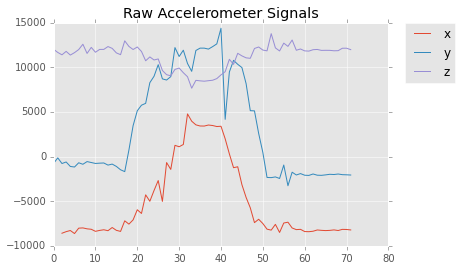

In [254]:
plt.plot(df['ax'], label='x')
plt.plot(df['ay'], label='y')
plt.plot(df['az'], label='z')
plt.title('Raw Accelerometer Signals')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

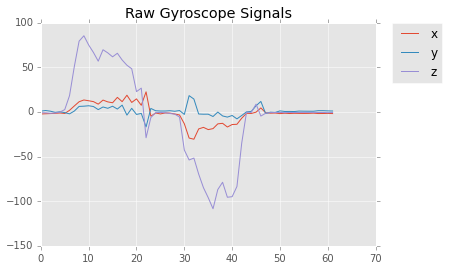

In [266]:
plt.plot(df['gx'], label='x')
plt.plot(df['gy'], label='y')
plt.plot(df['gz'], label='z')
plt.title('Raw Gyroscope Signals')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

In [268]:
def subtract_from_prev_val(df, col, init_val=0):
    return (df[col] - df.shift()[col])
    
def integrate_col(df, fxdx_col, dx_col, init_val):
    """
    Numeric integration from a panda data frame.
    Uses simply box method
    """
    fxdx_l = df[fxdx_col].tolist()
    dx_l = df[dx_col].tolist()
    prev_val = init_val
    y = [init_val]*len(df)
    for i in xrange(len(df)):
        y_val = prev_val + float(dx_l[i]) * fxdx_l[i]
        y[i] = y_val
        prev_val = y_val
    return np.array(y)

Integrate with f_x with \Delta x to get Y...:
$$ y[n] = y[n-1] + \Delta x * f_x[n]$$

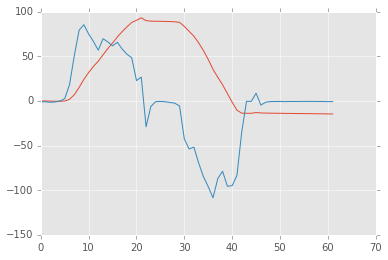

In [265]:
sensor_conv = 131.0
# wheel_rad = 0.110
wheel_rad = 1
df.drop(df.index[[i for i in xrange(10)]], inplace=True)
df['time_diff'] = subtract_from_prev_val(df, 'timestamp').fillna(0)/1000
pos = integrate_col(df, 'gz', 'time_diff', 0)
plt.plot(integrate_col(df, 'gz', 'time_diff', 0))
plt.plot(df['gz'])

In [270]:
df['theta'] = pos

# Calculate Left Turn Events

In [273]:
df['theta']

10     0.000000
11    -0.107166
12    -0.269116
13    -0.395641
14    -0.414404
15    -0.143806
16     1.721914
17     6.921318
18    15.033800
19    24.116855
20    31.780518
21    38.594194
22    44.414866
23    51.530710
24    58.570831
...
57   -13.686209
58   -13.766022
59   -13.838793
60   -13.902773
61   -13.991133
62   -14.056747
63   -14.127083
64   -14.195355
65   -14.254762
66   -14.316586
67   -14.374396
68   -14.446723
69   -14.513034
70   -14.603183
71   -14.679763
Name: theta, Length: 62, dtype: float64